In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import spikeinterface as si
import matplotlib.pyplot as plt
import os
from matplotlib.backends.backend_pdf import PdfPages
import os
import pickle
from tensorly.decomposition import non_negative_parafac

In [6]:
session_folder = os.listdir("/media/ubuntu/sda/neuropixels/output_dir")
session_list = []
for session in session_folder:
    if 'session_' in session:
        session_list.append(session)

In [296]:
cluster_inf_all = pd.DataFrame()
activity_dict = {}

for session in session_list:
    output_dir = f'/media/ubuntu/sda/neuropixels/output_dir/{session}'
    cluster_inf = pd.read_csv(f'{output_dir}/cluster_inf.csv')
    spike_inf = pd.read_csv(f'{output_dir}/spike_inf.csv', index_col=0)
    stimulus_table = pd.read_csv(f'{output_dir}/stimulus_table.csv')
    stimulus_table = stimulus_table[stimulus_table['frame']!= -1.0]
    stimulus_table['frame'] = stimulus_table['frame'].astype(int)

    filtered_spikes = spike_inf['id'].value_counts()
    filtered_spikes = filtered_spikes[filtered_spikes > 30000].index
    cluster_inf = cluster_inf[cluster_inf['unit_id'].isin(filtered_spikes)]
    spike_inf = spike_inf[spike_inf['id'].isin(filtered_spikes)]

    cluster_inf_all = pd.concat((cluster_inf_all, cluster_inf), axis = 0)

    for neuron in cluster_inf['unit_id']:
        spike_inf_temp = spike_inf[spike_inf['id'] == neuron]
        neuron = f'{neuron}_{session}'
        activity_dict[neuron] = {}
        for image in range(0, 118):
            activity_dict[neuron][image] = []

            trigger_time_temp = stimulus_table[(stimulus_table['frame'] == image)]

            for index, row in trigger_time_temp.iterrows():
                start = row['start_time']
                end = row['stop_time']

                filtered_spikes = spike_inf_temp[(spike_inf_temp['time'] >= start) &
                                                (spike_inf_temp['time'] <= end)]
                if not filtered_spikes.empty:
                    relative_spikes = (filtered_spikes['time'] - start) * 1000
                    activity_dict[neuron][image].append(np.array(relative_spikes))

In [297]:
with open("activity_dict_all_filtered_30000.pkl", 'wb') as f:
    pickle.dump(activity_dict, f)

In [230]:
from KDEpy import FFTKDE
def getResponseCurve(train_dict, total_trial_len, bw=None, samp_interval=1, MINBW=10, MAXBW=50):

    """Computes smooth trial-averaged response to a stim in all directions from spike trains
    using a kernel density estimator."""
    
    ts = np.arange(0,total_trial_len+samp_interval,samp_interval)
    x_ts = .5*(ts[:-1]+ts[1:]) #sample at the midpoints between sampling intervals

    all_ISJs = []
    
    
    fftkde = None

    for di,d in enumerate(sorted(train_dict)):

        full_train = []
        for triali,train in enumerate(train_dict[d]):
            if train.size == 0: continue
            #assert max(train) < total_trial_len
            full_train += list(train)    

        data = np.array(full_train)
        data.sort()
        n = data.size
        if fftkde is None:
            fftkde = FFTKDE(kernel='gaussian', bw=bw) #initialize kernel density estimator

        try:
            fftkde = fftkde.fit(data)
            #extend sampling one unit before and after trial
            ext_x_ts = np.r_[x_ts[0]-samp_interval,x_ts,x_ts[-1]+samp_interval]
            #then crop after applying the kernel
            y = fftkde.evaluate(ext_x_ts)[1:-1]

        except:
            #error occurs in the rare cases when there are zero spikes. print out to double-check
            print(f'fftkde failed: {n} data points')
            y = np.zeros_like(x_ts)


        all_ISJs.append(y*n*1000/len(train_dict[d])) #convert density to spks/sec
    return np.array(all_ISJs), x_ts


In [298]:
activity_dict_region = {}
for region in ['VISp', 'VISal', 'VISam', 'VISrl', 'VISpm', 'VISl']:
    activity_dict_region[region] = {}
    cluster_inf_temp = cluster_inf_all[cluster_inf_all['ecephys_structure_acronym'] == region]
    filtered_neuron = cluster_inf_temp['unit_id'].values

    for key, item in activity_dict.items():
        key = key.split("_")[0]
        if int(key) in filtered_neuron:
            activity_dict_region[region][key] = item


In [420]:
activity_df = {}
for region in ['VISp', 'VISal', 'VISam', 'VISrl', 'VISpm', 'VISl']:
    activity_df[region] = []
    for neuron in activity_dict_region[region].keys():
        all_ISJs, x_ts = getResponseCurve(activity_dict_region[region][neuron], total_trial_len=250, bw=50, samp_interval=10)
        activity_df[region].append(all_ISJs)

    activity_df[region]  = np.stack(activity_df[region] , axis=2)
    activity_df[region]  = np.transpose(activity_df[region] , axes=(2, 1, 0))

fftkde failed: 214 data points
fftkde failed: 161 data points
fftkde failed: 537 data points
fftkde failed: 549 data points
fftkde failed: 220 data points
fftkde failed: 97 data points
fftkde failed: 264 data points
fftkde failed: 243 data points
fftkde failed: 306 data points
fftkde failed: 202 data points
fftkde failed: 629 data points
fftkde failed: 463 data points
fftkde failed: 165 data points
fftkde failed: 252 data points
fftkde failed: 301 data points
fftkde failed: 899 data points
fftkde failed: 331 data points
fftkde failed: 284 data points
fftkde failed: 372 data points
fftkde failed: 1108 data points
fftkde failed: 392 data points
fftkde failed: 316 data points
fftkde failed: 213 data points
fftkde failed: 243 data points
fftkde failed: 546 data points
fftkde failed: 481 data points
fftkde failed: 277 data points
fftkde failed: 104 data points
fftkde failed: 297 data points
fftkde failed: 481 data points
fftkde failed: 450 data points
fftkde failed: 698 data points
fftkde f

In [422]:
activity_df['VISp'].shape

(464, 25, 118)

In [426]:
mean_fr = activity_df['VISp'].mean(axis = 1).mean(axis = 1)

In [15]:
with PdfPages("kde_heatmap.pdf") as pdf:
    for i in range(len(activity_df)):
        plt.figure(figsize=(10, 6))
        sns.heatmap(activity_df[i])
        plt.title(list(activity_dict.keys())[i])
        pdf.savefig()
        plt.close()

In [391]:
for i in range(activity_df['VISp'].shape[0]):
    max_value = activity_df['VISp'][i, :, :].max()
    activity_df['VISp'][i, :, :] /= max_value


In [392]:
fit_list = []
for rank in range(1, 100):
    factors = non_negative_parafac(
        activity_df['VISp'], 
        rank=rank,
        init='random',
        verbose=0
    )

    reconstructed = factors.to_tensor()
    norm_tensor = np.linalg.norm(activity_df['VISp'])
    norm_residual = np.linalg.norm(activity_df['VISp'] - reconstructed)
    fit = 100 * (1 - norm_residual / norm_tensor)
    fit_list.append(fit)

<Axes: >

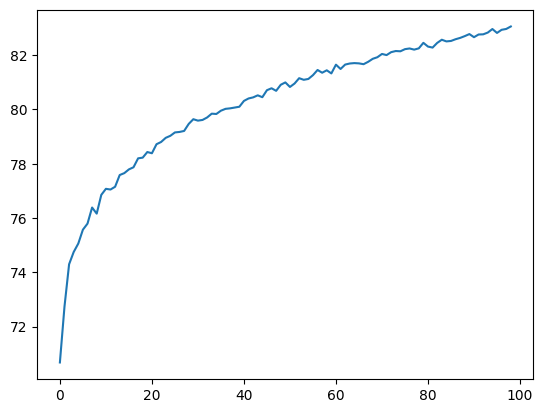

In [393]:
sns.lineplot(fit_list)

In [302]:
activity_df.keys()

dict_keys(['VISp', 'VISal', 'VISam', 'VISrl', 'VISpm', 'VISl'])

In [546]:
factors = non_negative_parafac(
        activity_df_scaled,
        rank=60,
        init='random',
        verbose=0
    )

In [547]:
neuron_factor, activity_factor, stimulus_factor = factors.factors

In [548]:
neuron_factor_max = np.max(neuron_factor, axis=0)
neuron_factor /= neuron_factor_max

In [549]:
stimulus_factor_max = np.max(stimulus_factor, axis=0)
stimulus_factor /= stimulus_factor_max

In [404]:
neuron_factor.shape

(464, 60)

In [550]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca_data = pca.fit_transform(neuron_factor)

In [551]:
max_fr = activity_df['VISp'].max(axis = 1).max(axis = 1)

In [552]:
position = pd.read_csv("/home/ubuntu/Downloads/dream/neuropixels_platform_paper-master/data/layer_info.csv")

In [553]:
position['cortical_layer'].value_counts()

cortical_layer
0    50136
5    13154
1    11326
2     9403
4     6470
6     5536
3     3155
Name: count, dtype: int64

In [554]:
cluster_inf_all[cluster_inf_all['ecephys_structure_acronym'] == 'VISp']['unit_id']

102    951001949
105    951002099
108    951002207
112    951002233
118    951002436
         ...    
96     951910719
99     951910733
114    951910832
117    951910868
118    951910924
Name: unit_id, Length: 464, dtype: int64

In [555]:
cluster_inf_VISp = cluster_inf_all[cluster_inf_all['ecephys_structure_acronym'] == 'VISp']
waveform_VISp = cluster_inf_VISp.loc[:, ['waveform_PT_ratio', 'waveform_amplitude', #'waveform_recovery_slope',
                                         'waveform_repolarization_slope', 'waveform_duration']]

for i in [0, 1, 2, 3]:
    max_data = waveform_VISp.iloc[:, i].max()
    waveform_VISp.iloc[:, i] /= max_data

In [556]:
pca = PCA(n_components=2)
waveform_pca = pca.fit_transform(np.array(waveform_VISp))

<Axes: xlabel='waveform_PT_ratio', ylabel='waveform_repolarization_slope'>

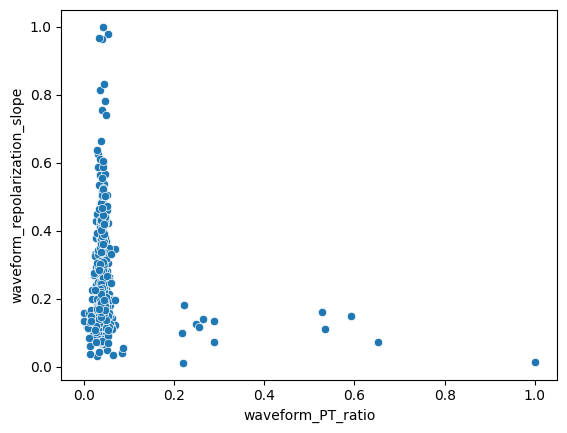

In [557]:
sns.scatterplot(x = waveform_VISp['waveform_PT_ratio'],
                y = waveform_VISp['waveform_repolarization_slope'])

<Axes: xlabel='waveform_PT_ratio', ylabel='waveform_duration'>

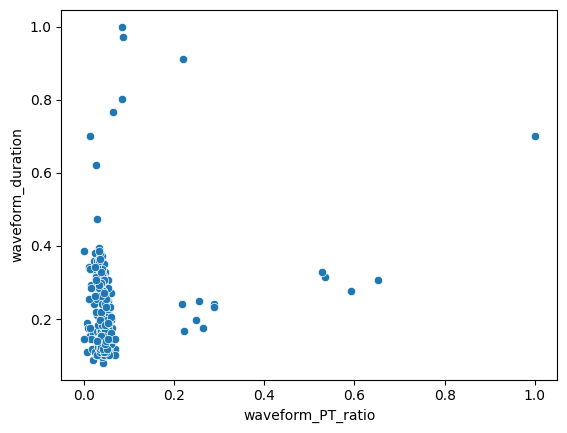

In [558]:
sns.scatterplot(x = waveform_VISp['waveform_PT_ratio'],
                y = waveform_VISp['waveform_duration'])

<Axes: >

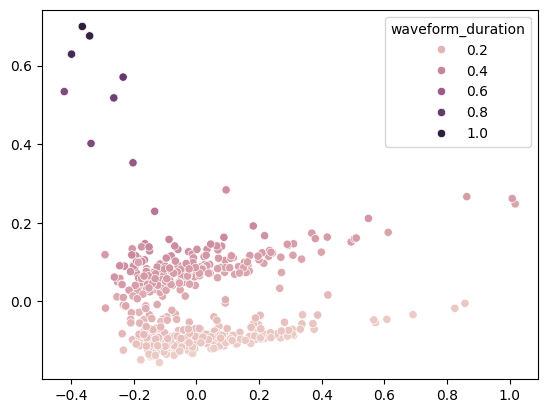

In [559]:
sns.scatterplot(x = waveform_pca[:, 0],
             y = waveform_pca[:, 1],
             hue=waveform_VISp['waveform_duration'])

In [560]:
position = position[position['ecephys_unit_id'].isin(cluster_inf_all[cluster_inf_all['ecephys_structure_acronym'] == 'VISp']['unit_id'].values)]

In [561]:
position['cortical_layer'].value_counts()

cortical_layer
5    177
0    101
4     91
2     49
6     46
Name: count, dtype: int64

In [562]:
from pydiffmap import diffusion_map
dm = diffusion_map.DiffusionMap.from_sklearn(n_evecs = 5, epsilon = 1.0, alpha = 0.5, k=64)
diffusion_coordinates = dm.fit_transform(neuron_factor)

<Axes: >

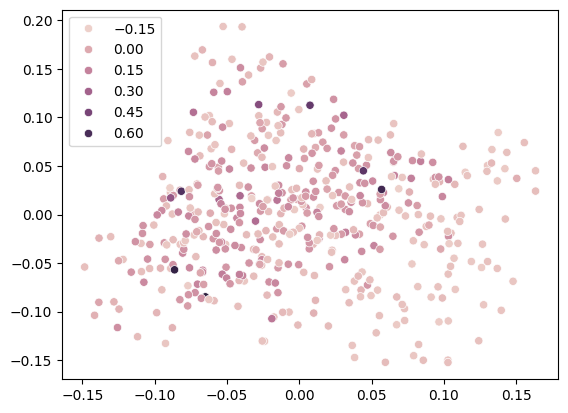

In [563]:
sns.scatterplot(x = diffusion_coordinates[:, 1],
        y = diffusion_coordinates[:, 2],
        hue=waveform_pca[:, 1])

In [567]:
import plotly.graph_objects as go
import nbformat


# 创建 3D 散点图
fig = go.Figure(data=[
    go.Scatter3d(
        x=diffusion_coordinates[:, 0], 
        y=diffusion_coordinates[:, 1], 
        z=diffusion_coordinates[:, 3],
        mode='markers',  # 纯点图模式
        marker=dict(
            size=3,               # 点大小
            colorscale='bluered',  # 颜色方案
            opacity=1,           # 透明度
            color = waveform_pca[:, 1],
            colorbar=dict(title='Z-Value')  # 添加颜色条
    ))
])

# 设置图表布局
fig.update_layout(
    title='3D 点图示例',
    scene=dict(
        xaxis_title='X 轴',
        yaxis_title='Y 轴',
        zaxis_title='Z 轴',
        camera=dict(eye=dict(x=1.5, y=1.5, z=0.1))  # 调整初始视角
    ),
    width=800,  # 图像宽度
    height=600  # 图像高度
)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': {'bdata': ('0FGJtQxsvr9kCBRx4Ha9vyxkWl+JuL' ... 'LKubu/YBm9amgBpj8SSnv3MCHkPw=='),
                                   'dtype': 'f8'},
                         'colorbar': {'title': {'text': 'Z-Value'}},
                         'colorscale': [[0.0, 'rgb(0,0,255)'], [1.0,
                                        'rgb(255,0,0)']],
                         'opacity': 1,
                         'size': 3},
              'mode': 'markers',
              'type': 'scatter3d',
              'x': {'bdata': ('+zHGT3AlyL8iVvXWglDGv+o0kja7e5' ... '+T3cA/bj3lA+ncxr+kA8b8sBfBPw=='),
                    'dtype': 'f8'},
              'y': {'bdata': ('ZjLoK85juz8fCQ7eSlDAP9ioT41jW5' ... '3UNsA/ar+FDxdQpT/9KHH5eh+tPw=='),
                    'dtype': 'f8'},
              'z': {'bdata': ('J8jLS+TuiL9q7SohGWhlvy7kPkGbsX' ... 'JQFcO/16y0c6/wob+8Uj41J4e1vw=='),
                    'dtype': 'f8'}}],
    'layout': {'height': 600,
               'scene': {'camera': {'eye': {'x': 1.5, 'y': 1.5, 'z': 0.1}},
                         'xaxis': {'title': {'text': 'X 轴'}},
                         'yaxis': {'title': {'text': 'Y 轴'}},
                         'zaxis': {'title': {'text': 'Z 轴'}}},
               'template': '...',
               'title': {'text': '3D 点图示例'},
               'width': 800}
})

In [ ]:
import numpy as np
from scipy.ndimage import uniform_filter1d

def spike_times_to_firing_rate(spike_times, time_range=250, kernel_size=25, stride=1):
    """
    将神经元发放时间点转换为发放率序列
    
    参数:
        spike_times (list): 神经元发放时间点的列表 (值在0-249范围内)
        time_range (int): 时间范围长度 (默认250)
        kernel_size (int): 池化核大小 (默认25)
        stride (int): 滑动步长 (默认1)
        
    返回:
        np.ndarray: 平均池化后的发放率序列
    """
    # 1. 创建250维的二进制向量 (时间序列)
    spike_train = np.zeros(time_range, dtype=np.float32)
    
    # 将发放时间点转换为整数索引
    valid_times = [int(t) for t in spike_times if 0 <= t < time_range]
    
    # 在发放时间点处设置为1
    spike_train[valid_times] = 1.0
    
    pooled = uniform_filter1d(spike_train, size=kernel_size, mode='constant')
    
    start_idx = (kernel_size - 1) // 2
    end_idx = -(kernel_size // 2)
    if end_idx == 0:  # 处理偶数核大小的情况
        end_idx = None
    
    result = pooled[start_idx:end_idx:stride]
    return result

In [195]:
activity_dict_region['VISp'].keys()

dict_keys(['951001742', '951001732', '951001889', '951001949', '951002099', '951002146', '951002133', '951002207', '951002347', '951002262', '951002233', '951002287', '951002398', '951002469', '951002436', '951002426', '951002514', '951002502', '951002954', '951002808', '951002796', '951002854', '951002781', '950930145', '950930105', '950930276', '950930215', '950930358', '950930423', '950930407', '950930375', '950930866', '950930795', '950930985', '950930964', '950931043', '950931181', '950931254', '950931423', '950931363', '950933840', '950931458', '950931315', '950931565', '950931533', '950931517', '950931656', '950931617', '950931581', '950931770', '950931751', '950931727', '950931853', '950931959', '950931899', '950932102', '950932087', '950932032', '950932563', '951785493', '951785584', '951785569', '951785620', '951785595', '951785683', '951785629', '951785671', '951785667', '951785658', '951785654', '951785643', '951785624', '951785692', '951785719', '951785714', '951785755', '

In [201]:
a = spike_times_to_firing_rate(activity_dict_region['VISp']['915960262'][0][0])

In [340]:
from sklearn.neighbors import NearestNeighbors
from scipy.linalg import eigh, inv
from scipy.sparse import diags, eye
from sklearn.preprocessing import normalize

n_samples = neuron_factor.shape[0]

knn = NearestNeighbors(n_neighbors = 10).fit(neuron_factor)
distances, indices = knn.kneighbors(neuron_factor)


In [341]:
W = np.zeros((n_samples, n_samples))
for i in range(n_samples):
    neighbors = indices[i]
    X_neighbors = neuron_factor[neighbors]

    cov = np.cov(X_neighbors, rowvar=False)
    reg_cov = cov + np.eye(neuron_factor.shape[1]) * np.trace(cov) / neuron_factor.shape[1]

    try:
        inv_cov = inv(reg_cov)
    except:
        inv_cov = np.linalg.pinv(reg_cov)

    diff = neuron_factor - neuron_factor[i]
    mahalanobis_dists = np.sqrt(np.sum(diff @ inv_cov * diff, axis= 1))


    W[i] = np.exp(-mahalanobis_dists ** 2)

W = (W + W.T) / 2

In [342]:
D = np.sum(W, axis=1)

D_alpha_sqrt_inv = diags(1 / np.sqrt(D))
W_tilde = D_alpha_sqrt_inv @ W @ D_alpha_sqrt_inv

D_tilde = np.sum(W_tilde, axis=1)


In [343]:
D_tilde_inv = diags(1/ D_tilde)
P = D_tilde_inv @ W_tilde

n_eigs = 5
eigenvalues, eigenvectors = eigh(P, subset_by_index=[n_samples - n_eigs, n_samples - 1])

sorted_idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_idx]
eigenvectors = eigenvectors[:, sorted_idx]

eigenvalues = eigenvalues[1:]
eigenvectors = eigenvectors[:, 1:]

diffusion_coords = eigenvectors * (eigenvectors ** 1)

<Axes: >

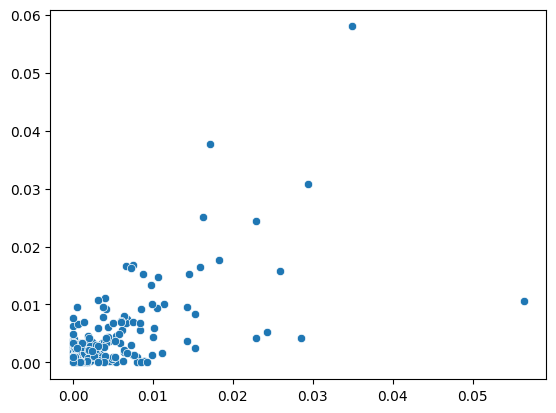

In [344]:
sns.scatterplot(x = diffusion_coords[:, 0],
                y = diffusion_coords[:, 1])